# Assignment 2 - CSC678

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
np.random.seed(1)

### Question 2
__a__. Implement 20 layer ResNet model (ResNet20) with the specification given on Page 7 of the paper for CIFAR-10 dataset.

#### CIFAR-10 Dataset :

- Number of Classes 10 <br>
- 50,000 training images <br>
- 10,000 testing images <br>
- image size  = 32 x 32 x 3 <br>
- 6000 images per class <br>
_do data set analysis exploratory data analysis _ <br>

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [46]:
print('Training Data shape  X=%s, y=%s'% (x_train.shape, y_train.shape))
print('Test Data shape  X=%s, y=%s'% (x_test.shape, y_test.shape))

Training Data shape  X=(50000, 32, 32, 3), y=(50000, 1)
Test Data shape  X=(10000, 32, 32, 3), y=(10000, 1)


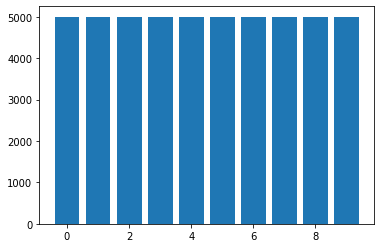

In [47]:
labels,counts = np.unique(y_train,return_counts=True)
plt.bar(labels,counts)
plt.show()

In [48]:
def to_categorical(x,num_of_classes):
    categorical  = np.zeros((x.shape[0],num_of_classes))
    count=0
    for sample in x:
        categorical[count][sample]=1
    return categorical

NameError: name 'ax' is not defined

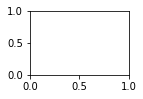

In [49]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i],ax)
plt.show()

***
#### ImageDataGenerator

ImageDataGenerator is a class in Tensorflow Keras which helps in 
1. Generating mini-batches for training <br>
2. Augmenting  and preprocessing images before they are loaded to a network for training <br>

Splitting Training data into training and validation according to the section 4.2 K. He et.al 2015

In [50]:
validation_size = 5000
validation_indices = np.random.choice(x_train.shape[0],validation_size,replace = False)
training_indices = np.array([i for i in range(x_train.shape[0]) if i not in validation_indices])
x_validation = x_train[validation_indices]
y_validation = y_train[validation_indices]
y_validation = to_categorical(y_validation, 10)
x_train_1 = x_train[training_indices]
y_train_1 = y_train[training_indices]
y_train_1 = to_categorical(y_train_1, 10)
print('Training Data shape  X=%s, y=%s'% (x_train_1.shape, y_train_1.shape))
print('Validation Data shape  X=%s, y=%s'% (x_validation.shape, y_validation.shape))

Training Data shape  X=(45000, 32, 32, 3), y=(45000, 10)
Validation Data shape  X=(5000, 32, 32, 3), y=(5000, 10)


Data augmentation is performed on the training data, according to the section 4.2 K. He et.al 2015,  <br>
but not on validation set.

In [51]:
batch_size = 128
train_size = 45e3
validation_size = 5e3
learning_rate = 0.1
iterations = 64e3
epochs = int(np.floor(iterations/(train_size/batch_size)))
steps_per_epoch = int(train_size/batch_size)

In [52]:
training_data_generator = ImageDataGenerator( 
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True).flow(x_train_1,y_train_1,batch_size=batch_size,shuffle=True)
validation_data_generator = ImageDataGenerator().flow(x_validation, y_validation, batch_size=batch_size,shuffle=True)

Inputs to the network are of the size 32 x 32 <br>

According Ke. He et. al in Section 4.2 there are total of 6n + 2 weighted layers <br>
- First layer is a 3 x 3 convolution with stride of 1
- Stack of 6n layers with 3 x 3 convolution layers of feature map sizes 32,16,8 with 2n layers of each feature map size.<br>
The number of filters in each 2n layer stack is 16,32,64
- Last layer is a fully connected layer for classification

***
For ResNet-20 the value of n = 3 <br>
- There are 3 stacks of 6 (2*3) layers with each stack containing different feature map(32,16,8) size and number of filters
- There are two type of shortcut connections <br>

    1.Skip connections within each stack where there is no change in dimensions <br>
     In this case Identity mapping is used. <br><br>
    2.Skip connections between stacks with change in dimensions <br>
    Projections shortcut is used to match dimensions using 1 x 1 convolutions
***
A residual building block function _residual_block_ is defined which contain convolution and batch normalization. This function can be called according to the ResNet size that we intend to analyze. <br>
Below is the function definition of the residual building block function.

In [53]:
def residual_block(inputs, number_of_filters=16, filter_size=3,strides=1,
                   activation='relu',batch_normalization=True):
    x = inputs    
    x = layers.Conv2D(number_of_filters, filter_size, strides, padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    if activation is not None:        
        x = layers.Activation(activation)(x)
    return x

In [54]:
def resnet20():  
    n = 3 # number of stacks
    layers_per_stack = 6
    number_of_filters = 16
    filter_size = 3
    inputs = layers.Input(shape=(32, 32, 3))
    x = residual_block(inputs)
    
    for stack in range(n):
    
        for layer in range(layers_per_stack):
            strides = 1
            if stack > 0 and layer==0:
                strides = 2
            y = residual_block(x,number_of_filters,filter_size,strides)
            y = residual_block(y,number_of_filters,filter_size,activation=None)
         
            if  stack > 0 and layer==0:
            # for reducing the dimension of the output of the skip-connection a 1x1 convolution is used 
            # with strides=2
                x = layers.Conv2D(filters=number_of_filters,kernel_size=1,strides=strides,activation=None,kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
            x = layers.add([x,y])
        
            # It must be noted that activation is applied to the second layer after the skip 
            # -connection is added
            x = layers.Activation('relu')(x)
            
        


        number_of_filters*=2

    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(10,activation='softmax',kernel_initializer='he_normal')(y)
    model = tf.keras.Model(inputs, outputs)
    return model


In [55]:
model = resnet20()

### b. Training using different optimizers

In [56]:
def learning_rate_schedule(epoch):
    learning_rate = 0.1
    learning_rate_scale_factor = 0.1
    if epoch > np.floor(3.2e4/(train_size/batch_size)):
        learning_rate*=learning_rate_scale_factor
    if epoch > np.floor(4.8e4/(train_size/batch_size)):
        learning_rate*=learning_rate_scale_factor
        
    return learning_rate
def tensorboard_callback():
    logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    return keras.callbacks.TensorBoard(log_dir=logdir)

In [57]:
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [58]:
callbacks = [lr_scheduler,tensorboard_callback]

#### I. SGD with momentum

In [59]:
momentum = 0.9
decay = 1e-4

In [60]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule(0),decay=decay,momentum=momentum)

In [61]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

In [62]:
model.fit_generator(training_data_generator, 
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_data_generator,
#                   callbacks=callbacks
                   )

Epoch 1/182
  3/351 [..............................] - ETA: 32:33 - loss: 0.2916 - accuracy: 0.8620

KeyboardInterrupt: 

#### II.  RMSProp

In [ ]:
rho = 0.9
rms_prop = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule(0),rho=rho)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=rms_prop, metrics=['accuracy'])

In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule(0),decay=decay,momentum=momentum)

In [ ]:
model.fit_generator(training_data_generator, 
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_data_generator,
#                   callbacks=callbacks
                   )

#### III. Adam

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule(0), beta_1=0.9, beta_2=0.999, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
model.fit_generator(training_data_generator, 
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_data_generator,
#                   callbacks=callbacks
                   )

__d__ . ResNet-18 pretrained model

In [ ]:
# https://github.com/qubvel/classification_models

In [ ]:
renet18 = load_model('pretrained_weights/resnet18_imagenet_1000_no_top.h5')